# Sistema di Pianificazione Progetti (con LangChain)

### Introduzione

Questo notebook implementa un sistema di pianificazione progetti utilizzando LangChain, una libreria dedicata alla creazione di applicazioni basate su modelli di linguaggio.    
**Il sistema analizza una descrizione di un progetto e genera un rapporto dettagliato che copre vari aspetti della pianificazione del progetto.**
    

    
### Struttura dell'Applicazione


```
                   +--------------------------------------+
                   |        Input Descrizione Progetto    |
                   +--------------------------------------+
                                     |
                                     v
         +--------------------------------------------------+
         | Conversione in Dizionario                        |
         | Input: Stringa descrizione                       |
         | Output: {"project_description": descrizione}     |
         +--------------------------------------------------+
                                     |
                                     v
       +----------------------------------------------------------+
       | Parallel: Analisi Ambito e Mantenimento Descrizione      |
       +----------------------------------------------------------+
                    |                             |
                    v                             v
        +-------------------------+   +---------------------------+
        |      Analisi Ambito     |   |     Passa Descrizione     |
        | Input: Descrizione      |   | Input: Descrizione        |
        | Output: Ambito Progetto |   | Output: Descrizione       |
        +-------------------------+   +---------------------------+
                    |                             |
                    v                             v
       +----------------------------------------------------------+
       | Output: Ambito Progetto e Descrizione                    |
       +----------------------------------------------------------+
                                     |
                                     v
                   +--------------------------------------+
                   | Debug: Stampa Ambito e Descrizione   |
                   +--------------------------------------+
                                     |
                                     v
         +--------------------------------------------------+
         | Analisi Requisiti Tecnici                        |
         | Input: Ambito e Descrizione                      |
         | Output: Requisiti Tecnici                        |
         +--------------------------------------------------+
                                     |
                                     v
                   +--------------------------------------+
                   | Debug: Stampa Requisiti Tecnici      |
                   +--------------------------------------+
                                     |
                                     v
+----------------------------------------------------------------------------+
| Parallel: Task Breakdown, Analisi Mercato, e Mantenimento Dati Precedenti  |
+----------------------------------------------------------------------------+
     |                |                |                |                |
     v                v                v                v                v
+------------+ +-------------+ +---------------+ +----------------+ +---------+
|    Task    | |  Analisi    | | Mantieni      | |   Mantieni     | | Mantieni|
| Breakdown  | |  Mercato    | | Ambito        | |   Requisiti    | | Descriz.|
+------------+ +-------------+ +---------------+ +----------------+ +---------+
     |                |                |                |                |
     v                v                v                v                v
+----------------------------------------------------------------------------+
| Output: Task Breakdown, Analisi Mercato, Ambito, Requisiti, Descrizione    |
+----------------------------------------------------------------------------+
                                     |
                                     v
                   +--------------------------------------+
                   | Debug: Stampa Tutti i Dati Raccolti  |
                   +--------------------------------------+
                                     |
                                     v
+----------------------------------------------------------------------------+
| Parallel: Stima Risorse, Valutazione Rischi, e Mantenimento Dati Precedenti|
+----------------------------------------------------------------------------+
     |           |           |           |           |           |
     v           v           v           v           v           v
+----------+ +----------+ +----------+ +----------+ +----------+ +----------+
|  Stima   | |Valutaz.  | | Mantieni | | Mantieni | | Mantieni | | Mantieni |
| Risorse  | | Rischi   | |  Tech    | |  Task    | | Mercato  | | Ambito   |
+----------+ +----------+ +----------+ +----------+ +----------+ +----------+
     |           |           |           |           |           |
     v           v           v           v           v           v
+----------------------------------------------------------------------------+
| Output Finale: Risorse, Rischi, Tech, Task, Mercato, Ambito                |
+----------------------------------------------------------------------------+
                                     |
                                     v
                   +--------------------------------------+
                   | Debug: Stampa Output Finale          |
                   +--------------------------------------+
```

## Metodi Principali


 
    
#### 1. Funzioni di Analisi (es. `analyze_scope`, `analyze_tech_requirements`, ecc.)

Queste funzioni seguono un pattern comune:

1. Definiscono un template di prompt
2. Creano un'istanza di `PromptTemplate`
3. Invocano il modello di linguaggio
4. Parsano l'output 
    
Questo approccio modulare permette di gestire separatamente ogni aspetto dell'analisi del progetto, mantenendo al contempo una struttura coerente.    
    
#### 2. `main_chain`

```python
main_chain = RunnableSequence(
    RunnableLambda(lambda x: {"project_description": x}),
    RunnableParallel({
        "scope": RunnableLambda(analyze_scope),
        "project_description": lambda x: x["project_description"]
    }),
    # ... altre operazioni ...
)
```

`main_chain` è il cuore dell'applicazione.    
Utilizza `RunnableSequence` e `RunnableParallel` di LangChain per creare un flusso di lavoro che:    
1. Prende la descrizione del progetto come input
2. Esegue varie analisi in parallelo dove possibile
3. Combina i risultati in un unico dizionario
    
Questo approccio permette un'esecuzione efficiente e parallelizzata delle varie componenti di analisi.    
    
#### 3. `generate_final_report`

Funzione per prendere i risultati aggregati dell'analisi e formattarli in un report finale leggibile.    
Le sezioni più complesse (dettagli dei task e strategie di mitigazione dei rischi) vengono generate dinamicamente.    

## Flusso di Esecuzione

1. L'utente fornisce una descrizione del progetto.
2. La descrizione viene passata attraverso `main_chain`, che esegue tutte le analisi necessarie.
3. I risultati vengono raccolti e passati a `generate_final_report`.
4. Il rapporto finale viene stampato o restituito all'utente.

In [1]:
import json
from langchain_core.prompts import PromptTemplate

from langchain_core.runnables import RunnableLambda, RunnableParallel,RunnableSequence
from typing import List, Dict, Any

In [2]:
# Configurazione del LLM
# I modelli instruct sono modelli che NON sono stati addestrati per tenere conversazioni
# ma solo modelli addestrati a fare Q&A: domanda diretta -> risposta diretta
# e non restituiscono oggetti di tipo AIMessage come i modelli chat, ma restituiscono dizionari
# Poiché noi lavoreremo sui dizionari e non abbiamo bisogno di chattare, per comodità utilizziamo un modello instruct

from langchain.chat_models import init_chat_model

llm = init_chat_model(model="gpt-4o-mini", temperature=.5)
#llm = init_chat_model("ollama:gemma3",temperature=.5,)


In [3]:
from typing_extensions import TypedDict, Annotated

In [4]:
# Definizione del template per l'analisi dell'ambito del progetto
# servirà come prompt per il modello di linguaggio,
# chiedendo di analizzare la descrizione del progetto e fornire
# informazioni specifiche sull'ambito del progetto.
SCOPE_TEMPLATE = """Analizza il seguente progetto e definisci il suo ambito:
Progetto: {project_description}
Fornisci: 1) Funzionalità principali, 2) Tipi di utenti target, 3) Piattaforme di sviluppo
"""

# Definizione del modello Pydantic per strutturare l'output dell'analisi dell'ambito
# specificando i campi richiesti e le loro descrizioni.
class ProjectScope(TypedDict):
    """A project scope definition."""
    main_features: Annotated[List[str], ..., "Funzionalità principali del progetto"]
    target_users: Annotated[List[str], ..., "Tipi di utenti target del progetto"]
    platforms: Annotated[List[str], ..., "Piattaforme su cui il progetto sarà sviluppato"]
 

# Funzione per analizzare l'ambito del progetto
def analyze_scope(project_description: str) -> Dict[str, Any]:
    """"
    Creazione di un prompt formattato che include:
        # 1. Il template SCOPE_TEMPLATE
        # 2. La descrizione del progetto come variabile di input
        # 3. Istruzioni di formattazione basate sul modello ProjectScope
    """
    prompt = PromptTemplate(      template=SCOPE_TEMPLATE,        input_variables=["project_description"],)

    result = llm.with_structured_output(ProjectScope,method="json_schema",).invoke(prompt.format(project_description=project_description))    

    print(f"\n\nOutput grezzo dell'LLM per l'analisi: {result}")

    return result

In [5]:
##test
project_description = """
Sviluppare una piattaforma di e-learning che offra corsi online interattivi 
su vari argomenti tecnologici. La piattaforma deve supportare video lezioni, 
quiz interattivi, forum di discussione e un sistema di monitoraggio dei progressi 
degli studenti. Dovrebbe essere accessibile via web e tramite app mobile, 
con funzionalità offline per alcune risorse di apprendimento.
"""

scope = analyze_scope(project_description)



Output grezzo dell'LLM per l'analisi: {'main_features': ['Video lezioni interattive', 'Quiz interattivi', 'Forum di discussione', 'Sistema di monitoraggio dei progressi', 'Accessibilità offline per alcune risorse', 'Interfaccia user-friendly per studenti e istruttori'], 'target_users': ['Studenti universitari', 'Professionisti in cerca di aggiornamento', 'Appassionati di tecnologia', 'Insegnanti e formatori', 'Aziende che desiderano formare i propri dipendenti'], 'platforms': ['Web', 'App mobile (iOS e Android)']}


In [6]:
scope

{'main_features': ['Video lezioni interattive',
  'Quiz interattivi',
  'Forum di discussione',
  'Sistema di monitoraggio dei progressi',
  'Accessibilità offline per alcune risorse',
  'Interfaccia user-friendly per studenti e istruttori'],
 'target_users': ['Studenti universitari',
  'Professionisti in cerca di aggiornamento',
  'Appassionati di tecnologia',
  'Insegnanti e formatori',
  'Aziende che desiderano formare i propri dipendenti'],
 'platforms': ['Web', 'App mobile (iOS e Android)']}

In [7]:
TECH_REQ_TEMPLATE = """Basandoti sulla descrizione e l'ambito del progetto, definisci i requisiti tecnici:
Progetto: {project_description}
Ambito: {project_scope}
Fornisci: 1) Tecnologie backend, 2) Tecnologie frontend, 3) Tipo di database, 4) API esterne necessarie 
"""

class TechnicalRequirements(TypedDict):
    backend_tech: Annotated[List[str], ..., "Tecnologie backend richieste"]
    frontend_tech: Annotated[List[str], ..., "Tecnologie frontend richieste"]
    database: Annotated[str, ..., "database da utilizzare"]
    apis: Annotated[List[str], ..., "API esterne necessarie"]
 

def analyze_tech_requirements(data: Dict[str, Any]) -> Dict[str, Any]:
    prompt = PromptTemplate(        template=TECH_REQ_TEMPLATE,     input_variables=["project_description", "project_scope"],     )
    result = llm.with_structured_output(TechnicalRequirements,method="json_schema") .invoke(prompt.format(**data))
    
    print(f"\n\nOutput grezzo dell'LLM per i requisiti tecnici: {result}")
    return result

In [8]:
## TEST
techReq = analyze_tech_requirements({'project_description': project_description, 'project_scope': scope})



Output grezzo dell'LLM per i requisiti tecnici: {'backend_tech': ['Node.js', 'Express.js', 'Django', 'Ruby on Rails'], 'frontend_tech': ['React', 'Vue.js', 'Angular', 'HTML5', 'CSS3'], 'database': 'PostgreSQL', 'apis': ['API per video hosting (es. Vimeo, YouTube)', 'API di autenticazione (es. OAuth2)', 'API di pagamento (es. Stripe, PayPal)', 'API per invio notifiche push (es. Firebase Cloud Messaging)']}


In [9]:
techReq

{'backend_tech': ['Node.js', 'Express.js', 'Django', 'Ruby on Rails'],
 'frontend_tech': ['React', 'Vue.js', 'Angular', 'HTML5', 'CSS3'],
 'database': 'PostgreSQL',
 'apis': ['API per video hosting (es. Vimeo, YouTube)',
  'API di autenticazione (es. OAuth2)',
  'API di pagamento (es. Stripe, PayPal)',
  'API per invio notifiche push (es. Firebase Cloud Messaging)']}

In [10]:
TASK_TEMPLATE = """Crea una suddivisione dettagliata dei task per il progetto:
Progetto: {project_description}
Ambito: {project_scope}
Requisiti Tecnici: {tech_requirements}
Fornisci: 1) Fasi principali del progetto, 2) Compiti specifici per ogni fase 
"""

class TaskBreakdown(TypedDict):
    phases: Annotated[List[str], ..., "Fasi principali del progetto"]
    tasks:  Annotated[Dict[str, List[str]], ..., "Compiti specifici per ogni fase"] 
 
    
def create_task_breakdown(data: Dict[str, Any]) -> Dict[str, Any]:
    prompt = PromptTemplate( template=TASK_TEMPLATE,  input_variables=["project_description", "project_scope", "tech_requirements"],     )

    result = llm.with_structured_output(TaskBreakdown,method="json_schema").invoke(prompt.format(**data))

    print(f"\n\nOutput grezzo dell'LLM per la suddivisione dei task: {result}")

    return result

In [11]:
## TEST
breaktask = create_task_breakdown({'project_description': project_description, 'project_scope': scope, 'tech_requirements': techReq})



Output grezzo dell'LLM per la suddivisione dei task: {'phases': ['Analisi e Pianificazione', "Progettazione dell'Architettura", 'Sviluppo del Backend', 'Sviluppo del Frontend', 'Integrazione delle Funzionalità', 'Testing e QA', 'Implementazione e Lancio', 'Manutenzione e Aggiornamenti'], 'tasks': {'Analisi e Pianificazione': ['Raccogliere i requisiti degli utenti e delle parti interessate', 'Definire gli obiettivi del progetto e le metriche di successo', 'Stabilire il budget e le risorse necessarie', 'Creare un piano di progetto dettagliato con scadenze'], "Progettazione dell'Architettura": ["Definire l'architettura del sistema (frontend, backend, database)", 'Selezionare le tecnologie da utilizzare (Node.js, React, PostgreSQL, etc.)', 'Progettare il database e le relazioni tra le entità', "Creare wireframe e mockup per l'interfaccia utente"], 'Sviluppo del Backend': ["Impostare l'ambiente di sviluppo per il backend", "Creare l'API RESTful per gestire le operazioni CRUD", 'Implementa

In [12]:
breaktask

{'phases': ['Analisi e Pianificazione',
  "Progettazione dell'Architettura",
  'Sviluppo del Backend',
  'Sviluppo del Frontend',
  'Integrazione delle Funzionalità',
  'Testing e QA',
  'Implementazione e Lancio',
  'Manutenzione e Aggiornamenti'],
 'tasks': {'Analisi e Pianificazione': ['Raccogliere i requisiti degli utenti e delle parti interessate',
   'Definire gli obiettivi del progetto e le metriche di successo',
   'Stabilire il budget e le risorse necessarie',
   'Creare un piano di progetto dettagliato con scadenze'],
  "Progettazione dell'Architettura": ["Definire l'architettura del sistema (frontend, backend, database)",
   'Selezionare le tecnologie da utilizzare (Node.js, React, PostgreSQL, etc.)',
   'Progettare il database e le relazioni tra le entità',
   "Creare wireframe e mockup per l'interfaccia utente"],
  'Sviluppo del Backend': ["Impostare l'ambiente di sviluppo per il backend",
   "Creare l'API RESTful per gestire le operazioni CRUD",
   'Implementare il sistem

In [13]:
MARKET_TEMPLATE = """Fai una analisi di mercato mercato per il seguente progetto:
Progetto: {project_description}
Ambito: {project_scope}
Fornisci: 1) Dimensione stimata del mercato target, 2) Principali concorrenti, 3) Punti di forza unici 
"""

class MarketAnalysis(TypedDict):
    target_market_size: Annotated[str, ..., "Dimensione stimata del mercato target"]
    main_competitors:  Annotated[List[str], ..., "Principali concorrenti"] 
    unique_selling_points: Annotated[List[str], ..., "Punti di forza unici del progetto"]
 

def analyze_market(data: Dict[str, Any]) -> Dict[str, Any]:
    prompt = PromptTemplate(   template=MARKET_TEMPLATE, input_variables=["project_description", "project_scope"],    )

    result = llm.with_structured_output(MarketAnalysis,method="json_schema") .invoke(prompt.format(**data))
    print(f"\n\nOutput grezzo dell'LLM per l'analisi di mercato: {result}")
    return result

In [14]:
## TEST
market = analyze_market({'project_description': project_description, 'project_scope': scope})



Output grezzo dell'LLM per l'analisi di mercato: {'target_market_size': "Il mercato globale dell'e-learning è stimato in circa 300 miliardi di dollari entro il 2025, con una crescita annuale del 10-15%. Il segmento dei corsi online interattivi sta crescendo rapidamente, con milioni di studenti e professionisti che cercano opportunità di apprendimento flessibili e accessibili.", 'main_competitors': ['Coursera', 'Udemy', 'edX', 'Skillshare', 'LinkedIn Learning', 'Khan Academy'], 'unique_selling_points': ['Corsi interattivi con video lezioni e quiz per un apprendimento attivo', 'Forum di discussione per interazione tra studenti e istruttori', "Sistema di monitoraggio dei progressi per personalizzare l'esperienza di apprendimento", "Accessibilità offline per consentire l'apprendimento in qualsiasi momento e luogo", "Interfaccia user-friendly progettata per facilitare l'uso da parte di studenti e insegnanti", 'Focalizzazione su argomenti tecnologici di attualità e rilevanza nel mercato de

In [15]:
market

{'target_market_size': "Il mercato globale dell'e-learning è stimato in circa 300 miliardi di dollari entro il 2025, con una crescita annuale del 10-15%. Il segmento dei corsi online interattivi sta crescendo rapidamente, con milioni di studenti e professionisti che cercano opportunità di apprendimento flessibili e accessibili.",
 'main_competitors': ['Coursera',
  'Udemy',
  'edX',
  'Skillshare',
  'LinkedIn Learning',
  'Khan Academy'],
 'unique_selling_points': ['Corsi interattivi con video lezioni e quiz per un apprendimento attivo',
  'Forum di discussione per interazione tra studenti e istruttori',
  "Sistema di monitoraggio dei progressi per personalizzare l'esperienza di apprendimento",
  "Accessibilità offline per consentire l'apprendimento in qualsiasi momento e luogo",
  "Interfaccia user-friendly progettata per facilitare l'uso da parte di studenti e insegnanti",
  'Focalizzazione su argomenti tecnologici di attualità e rilevanza nel mercato del lavoro']}

In [16]:
RESOURCE_TEMPLATE = """Stima le risorse necessarie per il progetto:
Progetto: {project_description}
Suddivisione Task: {task_breakdown}
Fornisci: 1) Dimensione del team, 2) Ruoli necessari, 3) Timeline stimata, 4) Intervallo di budget 
"""
 

class ResourceEstimate(TypedDict):
    team_size: Annotated[int, ..., "Dimensione consigliata del team"]
    roles:  Annotated[List[str], ..., "Ruoli necessari nel team"] 
    timeline: Annotated[str, ..., "Stima del tempo totale di sviluppo"]
    budget_range: Annotated[str, ..., "Intervallo di budget stimato"]

def estimate_resources(data: Dict[str, Any]) -> Dict[str, Any]:
    prompt = PromptTemplate(    template=RESOURCE_TEMPLATE,     input_variables=["project_description", "task_breakdown"],     )

    result = llm.with_structured_output(ResourceEstimate,method='json_schema') .invoke(prompt.format(**data))

    print(f"\n\nOutput grezzo dell'LLM per la stima delle risorse: {result}")
    return result

In [17]:
## TEST
resource = estimate_resources({'project_description': project_description, 'task_breakdown': breaktask })



Output grezzo dell'LLM per la stima delle risorse: {'team_size': 8, 'roles': ['Project Manager', 'Business Analyst', 'UI/UX Designer', 'Frontend Developer', 'Backend Developer', 'QA Engineer', 'DevOps Engineer', 'Content Creator'], 'timeline': '6-12 mesi', 'budget_range': '€100,000 - €250,000'}


In [18]:
resource

{'team_size': 8,
 'roles': ['Project Manager',
  'Business Analyst',
  'UI/UX Designer',
  'Frontend Developer',
  'Backend Developer',
  'QA Engineer',
  'DevOps Engineer',
  'Content Creator'],
 'timeline': '6-12 mesi',
 'budget_range': '€100,000 - €250,000'}

In [19]:
RISK_TEMPLATE = """Valuta i rischi potenziali del progetto:
Progetto: {project_description}
Ambito: {project_scope}
Requisiti Tecnici: {tech_requirements}
Fornisci: 1) Rischi tecnici, 2) Rischi di business, 3) Strategie di mitigazione per i rischi principali
"""

class RiskAssessment(TypedDict):
    technical_risks: Annotated[List[str], ..., "Potenziali rischi tecnici"]
    business_risks: Annotated[List[str], ..., "Potenziali rischi di business"]
    mitigation_strategies: Annotated[Dict[str, str], ..., "Strategie di mitigazione per i rischi principali"]
                               

def assess_risks(data: Dict[str, Any]) -> Dict[str, Any]:
    prompt = PromptTemplate(        template=RISK_TEMPLATE,        input_variables=["project_description", "project_scope", "tech_requirements"],     )
    result = llm.with_structured_output(RiskAssessment, method="json_schema"  ).invoke(prompt.format(**data))
    print(f"Output grezzo dell'LLM per la valutazione dei rischi: {result}")
    return result

In [20]:
asses = assess_risks({'project_description': project_description, 'project_scope': scope, 'tech_requirements': techReq})

Output grezzo dell'LLM per la valutazione dei rischi: {'technical_risks': ['Integrazione complessa tra diverse tecnologie e API, che può portare a problemi di compatibilità.', 'Difficoltà nella gestione del carico di utenti simultanei, che può causare downtime o rallentamenti.', 'Problemi di sicurezza, come vulnerabilità alle violazioni dei dati o attacchi informatici.', "Difficoltà nella creazione di un'interfaccia user-friendly che soddisfi le aspettative degli utenti.", 'Problemi di accessibilità per utenti con disabilità, se non vengono rispettate le linee guida di accessibilità.'], 'business_risks': ["Concorrenza agguerrita nel mercato dell'e-learning, che può ridurre la quota di mercato.", "Difficoltà nel mantenere l'interesse degli utenti e ridurre il tasso di abbandono dei corsi.", 'Problemi di monetizzazione, come la difficoltà nel convertire gli utenti in clienti paganti.', 'Cambiamenti nelle normative o nelle politiche di privacy che possono influenzare il modello di busines

In [21]:
asses

{'technical_risks': ['Integrazione complessa tra diverse tecnologie e API, che può portare a problemi di compatibilità.',
  'Difficoltà nella gestione del carico di utenti simultanei, che può causare downtime o rallentamenti.',
  'Problemi di sicurezza, come vulnerabilità alle violazioni dei dati o attacchi informatici.',
  "Difficoltà nella creazione di un'interfaccia user-friendly che soddisfi le aspettative degli utenti.",
  'Problemi di accessibilità per utenti con disabilità, se non vengono rispettate le linee guida di accessibilità.'],
 'business_risks': ["Concorrenza agguerrita nel mercato dell'e-learning, che può ridurre la quota di mercato.",
  "Difficoltà nel mantenere l'interesse degli utenti e ridurre il tasso di abbandono dei corsi.",
  'Problemi di monetizzazione, come la difficoltà nel convertire gli utenti in clienti paganti.',
  'Cambiamenti nelle normative o nelle politiche di privacy che possono influenzare il modello di business.',
  'Rischi legati alla qualità dei 

### Creazione della catena

Creiamo la funzione che andiamo ad utilizzare per fare la print di debug dei log intermedi.

Importante notare come questa funzione prende in input un dizionario e restituisce in output un dizionario.
In questo modo possiamo includerla in mezzo alla nostra catana in cui sappiamo che un certo step precedente produrrà un dizionario e lo step successivo prenderà in input un dizionario

In [22]:
# Debug - log intermedi
def debug_print(data: Dict[str, Any]) -> Dict[str, Any]:
    print(f"\n\nDebug - Dati correnti: {json.dumps(data, indent=2)}") # indent=2
    return data

In [23]:
# test catena
test= RunnableSequence(
    RunnableLambda(lambda x: {"project_description": x}), 
    RunnableParallel(  { "scope": RunnableLambda(analyze_scope),  "project_description": lambda x: x["project_description"]  } ),
    RunnableLambda(debug_print),
    RunnableLambda( lambda x: {   **x,  "tech_requirements": analyze_tech_requirements({   "project_description": x["project_description"],     "project_scope": x["scope"]       })     }
    ),     
)

In [24]:
prova = test.invoke(project_description)



Output grezzo dell'LLM per l'analisi: {'main_features': ['Corsi online interattivi su vari argomenti tecnologici', 'Video lezioni', 'Quiz interattivi', 'Forum di discussione', 'Sistema di monitoraggio dei progressi degli studenti', 'Accessibilità via web', 'App mobile con funzionalità offline'], 'target_users': ['Studenti', 'Professionisti in cerca di aggiornamento', 'Insegnanti e formatori', 'Appassionati di tecnologia'], 'platforms': ['Web', 'iOS', 'Android']}


Debug - Dati correnti: {
  "scope": {
    "main_features": [
      "Corsi online interattivi su vari argomenti tecnologici",
      "Video lezioni",
      "Quiz interattivi",
      "Forum di discussione",
      "Sistema di monitoraggio dei progressi degli studenti",
      "Accessibilit\u00e0 via web",
      "App mobile con funzionalit\u00e0 offline"
    ],
    "target_users": [
      "Studenti",
      "Professionisti in cerca di aggiornamento",
      "Insegnanti e formatori",
      "Appassionati di tecnologia"
    ],
    "pl

RunnableSequence() è un altro modo diverso sintatticamente ma equivalente nel risultato di mettere elementi in catena.

Invece di avere a | b | ... | z posso fare RunnableSequence(a, b, ..., z)

In [25]:
# Catena principale
main_chain = RunnableSequence(
    RunnableLambda(lambda x: {"project_description": x}),  # recupero l'input e lo associo alla chiave `project_description`
    # {"project_description":"..."}
    RunnableParallel(
        {
            "scope": RunnableLambda(analyze_scope),  # lancio `analyze_scope`
            "project_description": lambda x: x["project_description"]  # mi porto avanti `project_description`
        }
    ),
    RunnableLambda(debug_print),  # chiamo la funzione di log
    # {"scope":"...", "project_description":"..."}
    RunnableLambda(
        lambda x: { 
            **x,  # "copia-incolla" le coppie chiave valore del dizionario di input in output
            "tech_requirements": analyze_tech_requirements({  # associa alla chiave `tech_requirements` il risultato della 
                                                              # funzione `analyze_tech_requirements`
                "project_description": x["project_description"],  # recupero di `project_description` per darlo in input
                                                                  # alla funzione `analyze_tech_requirements`
                "project_scope": x["scope"]  # Trasforma un type <dict> in un type <str>
            })
        }
    ), # {"scope":"...", "project_description":"...", "tech_requirements":"..."}
    RunnableLambda(debug_print),
    RunnableParallel(
        {
            "task_breakdown": RunnableLambda(lambda x: create_task_breakdown({
                "project_description": x["project_description"],
                "project_scope": x["scope"],
                "tech_requirements": x["tech_requirements"]
            })),
            "market_analysis": RunnableLambda(lambda x: analyze_market({
                "project_description": x["project_description"],
                "project_scope": x["scope"]
            })),
            "scope": lambda x: x["scope"],
            "tech_requirements": lambda x: x["tech_requirements"],
            "project_description": lambda x: x["project_description"]
        }
    ),#{"scope":"...", "project_description":"...", "tech_requirements":"...", "task_breakdown":"...", "market_analysis":"..."}
    RunnableLambda(debug_print),
    #{"scope":"...", "project_description":"...", "tech_requirements":"...", "task_breakdown":"...", "market_analysis":"..."}
    RunnableParallel(
        {
            "resources": RunnableLambda(lambda x: estimate_resources({
                "project_description": x["project_description"],
                "task_breakdown": x["task_breakdown"]
            })),
            "risks": RunnableLambda(lambda x: assess_risks({
                "project_description": x["project_description"],
                "project_scope": x["scope"],
                "tech_requirements": x["tech_requirements"]
            })),
            "tech_requirements": lambda x: x["tech_requirements"],
            "task_breakdown": lambda x: x["task_breakdown"],
            "market_analysis": lambda x: x["market_analysis"],
            "scope": lambda x: x["scope"]
        } #{"scope":"...", "tech_requirements":"...", "task_breakdown":"...", "market_analysis":"...", "resources":"...", "risks":"..."}
    ), 
    RunnableLambda(debug_print)
)

In [26]:
# Funzione per generare il rapporto finale
def generate_final_report(data: Dict[str, Any]) -> str:
    report_template = """
    Rapporto di Pianificazione del Progetto
    
    1. Ambito del Progetto:
    - Funzionalità principali: {scope[main_features]}
    - Utenti target: {scope[target_users]}
    - Piattaforme: {scope[platforms]}
    
    2. Requisiti Tecnici:
    - Backend: {tech_requirements[backend_tech]}
    - Frontend: {tech_requirements[frontend_tech]}
    - Database: {tech_requirements[database]}
    - API esterne: {tech_requirements[apis]}
    
    3. Suddivisione dei Task:
    - Fasi del progetto: {task_breakdown[phases]}
    - Dettaglio dei task per fase:
    {task_details}
    
    4. Stima delle Risorse:
    - Dimensione del team: {resources[team_size]}
    - Ruoli necessari: {resources[roles]}
    - Timeline stimata: {resources[timeline]}
    - Range di budget: {resources[budget_range]}
    
    5. Valutazione dei Rischi:
    - Rischi tecnici: {risks[technical_risks]}
    - Rischi di business: {risks[business_risks]}
    - Strategie di mitigazione:
    {risk_mitigation}
    
    6. Analisi di Mercato:
    - Dimensione del mercato target: {market_analysis[target_market_size]}
    - Principali concorrenti: {market_analysis[main_competitors]}
    - Punti di forza unici: {market_analysis[unique_selling_points]}
    """
    
    task_details = "\n".join([f"      {phase}:\n      - " + "\n      - ".join(tasks) for phase, tasks in data['task_breakdown']['tasks'].items()])
    risk_mitigation = "\n".join([f"    - {risk}: {strategy}" for risk, strategy in data['risks']['mitigation_strategies'].items()])
    
    return report_template.format(**data, task_details=task_details, risk_mitigation=risk_mitigation)

# Funzione principale per l'analisi del progetto
def analyze_project(project_description: str) -> str:
    result = main_chain.invoke(project_description)
    return generate_final_report(result)

In [27]:
report = analyze_project(project_description)



Output grezzo dell'LLM per l'analisi: {'main_features': ['Corsi online interattivi', 'Video lezioni', 'Quiz interattivi', 'Forum di discussione', 'Sistema di monitoraggio dei progressi', 'Accessibilità via web', 'App mobile con funzionalità offline'], 'target_users': ['Studenti', 'Professionisti in cerca di formazione continua', 'Insegnanti e formatori', 'Aziende che desiderano formare i propri dipendenti'], 'platforms': ['Web', 'App mobile (iOS e Android)']}


Debug - Dati correnti: {
  "scope": {
    "main_features": [
      "Corsi online interattivi",
      "Video lezioni",
      "Quiz interattivi",
      "Forum di discussione",
      "Sistema di monitoraggio dei progressi",
      "Accessibilit\u00e0 via web",
      "App mobile con funzionalit\u00e0 offline"
    ],
    "target_users": [
      "Studenti",
      "Professionisti in cerca di formazione continua",
      "Insegnanti e formatori",
      "Aziende che desiderano formare i propri dipendenti"
    ],
    "platforms": [
      

In [28]:
def get_report(project_description):
    # doppia chiamata a `analyze_project()` per
    # arginare eventuali errori di parsing
    try:
        report = analyze_project(project_description)
        return report
    except Exception as e:
        print("\n\n\n", "-" * 50)
        print(e)
        print("-" * 50, "\n\n\n")
        try:
            report = analyze_project(project_description)
            return report
        except Exception as e:
            print("\n\n\n", "-" * 50)
            print(e)
            print("-" * 50, "\n\n\n")
            return e
        return e

In [29]:
# Esecuzione dell'analisi del progetto
project_description = """
Sviluppare una piattaforma di e-learning che offra corsi online interattivi 
su vari argomenti tecnologici. La piattaforma deve supportare video lezioni, 
quiz interattivi, forum di discussione e un sistema di monitoraggio dei progressi 
degli studenti. Dovrebbe essere accessibile via web e tramite app mobile, 
con funzionalità offline per alcune risorse di apprendimento.
"""

report = get_report(project_description)



Output grezzo dell'LLM per l'analisi: {'main_features': ['Corsi online interattivi', 'Video lezioni', 'Quiz interattivi', 'Forum di discussione', 'Sistema di monitoraggio dei progressi', 'Accessibilità via web e app mobile', 'Funzionalità offline per risorse di apprendimento'], 'target_users': ['Studenti', 'Professionisti in cerca di aggiornamento', 'Insegnanti', 'Appassionati di tecnologia', 'Aziende per formazione dei dipendenti'], 'platforms': ['Web', 'App mobile (iOS e Android)']}


Debug - Dati correnti: {
  "scope": {
    "main_features": [
      "Corsi online interattivi",
      "Video lezioni",
      "Quiz interattivi",
      "Forum di discussione",
      "Sistema di monitoraggio dei progressi",
      "Accessibilit\u00e0 via web e app mobile",
      "Funzionalit\u00e0 offline per risorse di apprendimento"
    ],
    "target_users": [
      "Studenti",
      "Professionisti in cerca di aggiornamento",
      "Insegnanti",
      "Appassionati di tecnologia",
      "Aziende per f

In [30]:
print(report)


    Rapporto di Pianificazione del Progetto

    1. Ambito del Progetto:
    - Funzionalità principali: ['Corsi online interattivi', 'Video lezioni', 'Quiz interattivi', 'Forum di discussione', 'Sistema di monitoraggio dei progressi', 'Accessibilità via web e app mobile', 'Funzionalità offline per risorse di apprendimento']
    - Utenti target: ['Studenti', 'Professionisti in cerca di aggiornamento', 'Insegnanti', 'Appassionati di tecnologia', 'Aziende per formazione dei dipendenti']
    - Piattaforme: ['Web', 'App mobile (iOS e Android)']

    2. Requisiti Tecnici:
    - Backend: ['Node.js', 'Express.js', 'Django', 'Ruby on Rails']
    - Frontend: ['React', 'Vue.js', 'Angular', 'Flutter (per app mobile)']
    - Database: PostgreSQL
    - API esterne: ['API per video hosting (es. Vimeo, YouTube)', 'API di pagamento (es. Stripe, PayPal)', 'API per autenticazione (es. OAuth, JWT)', 'API per notifiche push (es. Firebase Cloud Messaging)']

    3. Suddivisione dei Task:
    - Fasi del pro

In [31]:
main_chain.get_graph().print_ascii()

                                                +-------------+                                                
                                                | LambdaInput |                                                
                                                +-------------+                                                
                                                       *                                                       
                                                       *                                                       
                                                       *                                                       
                                                  +--------+                                                   
                                                  | Lambda |                                                   
                                                  +--------+                                            

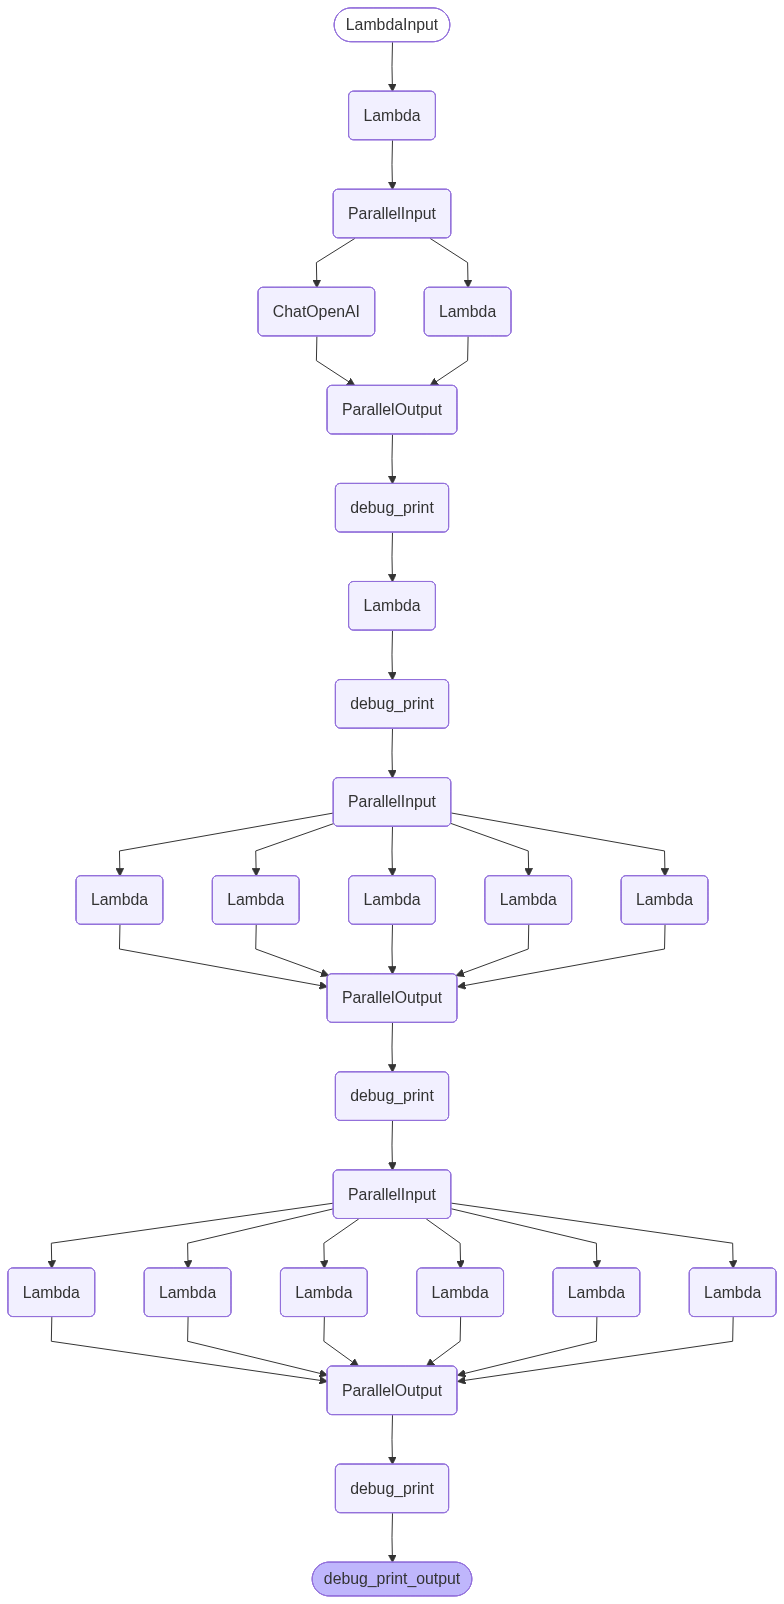

In [32]:
from IPython.display import Image, display

display(Image(main_chain.get_graph().draw_mermaid_png()))